
## Steps in this notebook:

#### Step 1: Load the model and the image

### Step 2: Create the Laplace mechanism function by modifying the original ML model's way of encoding the image

### Step 3: Plot different images (Original vs Encoded vs Encoded w. Noise) for CelebAHQ and PublicAHQ

In [33]:
import os
import sys
from PIL import Image,ImageShow
import numpy as np
import torch
import seaborn as sb
import matplotlib.pyplot as plt
import yaml
from omegaconf import OmegaConf
import torchvision.transforms as transforms

import main
import taming.modules.losses.vqperceptual
from taming.models.cond_transformer import Net2NetTransformer

###Get the dependencies

In [34]:
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops transformers

sys.path.append(".")

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\DripTooHard\PycharmProjects\taming-transformers2\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Prepare configurations of the CelebAHQ model as well as checkpoints.

In [35]:
#Prepare CelebAHQ configurations
config_path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq_transformer.yaml"
celebAHQ_config = OmegaConf.load(config_path)
print(yaml.dump(OmegaConf.to_container(celebAHQ_config)))

#Init model with the chosen architecture and configurations
model = Net2NetTransformer(**celebAHQ_config.model.params)

data:
  params:
    batch_size: 2
    num_workers: 8
    train:
      params:
        coord: true
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQTrain
    validation:
      params:
        coord: true
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQValidation
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        down_factor: 16
        n_embed: 1024
      target: taming.modules.misc.coord.CoordStage
    cond_stage_key: coord
    first_stage_config:
      params:
        ckpt_path: C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq.ckpt
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 3
          num_res_blocks: 2
          out_ch: 3
  

In [36]:
#Load checkpoints
ckpt_path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\configs\faceshq.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
model.load_state_dict(sd)
missing, unexpected = model.load_state_dict(sd, strict=False)

In [37]:
#Put model in evaluation mode
model.eval()
torch.set_grad_enabled(False)

In [38]:
#We look at the codebook to check whether or not it ressembles a normal distribution around 0.

norms = []

#Uncomment the code below to get a graph of how the freshly initialized codebook should look.
#model.first_stage_model.quantize.embedding.weight.data.uniform_(-1.0/(model.first_stage_model.quantize.n_e),1/(model.first_stage_model.quantize.n_e))

for codebook in model.first_stage_model.quantize.parameters():
    codebook
    for zq in codebook:
        norms += [np.linalg.norm(zq)]

#We know for a fact, that all norms will be equal to or less than 2 if it has just been instantiated
assert(len([norm for norm in norms if norm>2])>0)

## Load example data

Load an example segmentation and visualize.

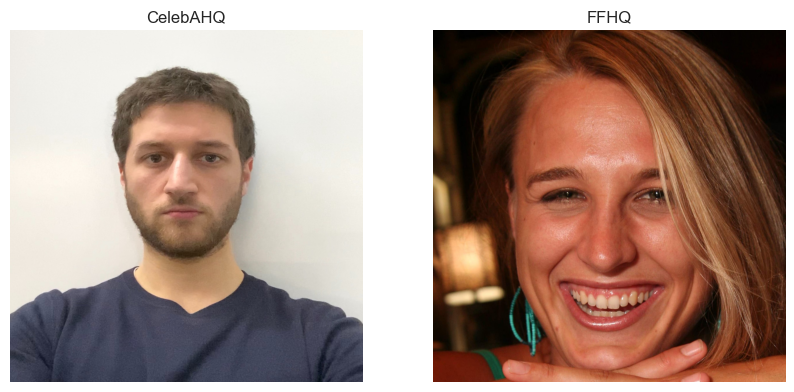

In [39]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Define the function to load an image as a tensor
def load_image_tensor(path):
    image = Image.open(path)
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(image).permute(1,2,0).float()/255
    return img_tensor.permute(2, 0, 1).unsqueeze(0)

# Load the images
AHQ_example_path = r"C:\Users\DripTooHard\Pictures\DivVisaApp.jpg"
FFHQ_example_path = r"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\data\FFHQ\00000\00001.png"

AHQ_image = load_image_tensor(AHQ_example_path)
FFHQ_image = load_image_tensor(FFHQ_example_path)

# Plot the images with titles
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(AHQ_image[0].permute(1, 2, 0))
plt.title('CelebAHQ')
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)
plt.imshow(FFHQ_image[0].permute(1, 2, 0))
plt.title('FFHQ')
plt.axis('off')  # Hide the axis

plt.show()


# Step 2: We now confirm, that it can correctly reconstruct the images.


In [40]:
def deconstruct_reconstruct(image):
    image = image.type(torch.FloatTensor)  # Ensure the image tensor is of type FloatTensor
    image_zq, image_z_indices = model.encode_to_z(image)
    image_recon = model.decode_to_img(image_z_indices, image_zq.shape)
    return image_recon

model.set_epsilon(0.9)
recon = deconstruct_reconstruct(AHQ_image)
recon = recon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


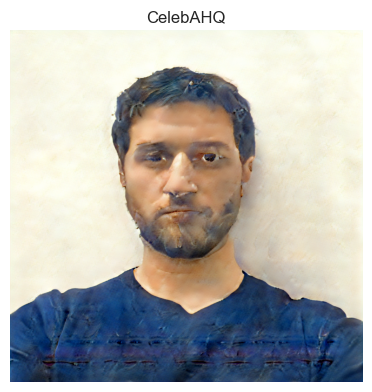

In [41]:
# Plot the images with titles
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(recon[0].float().permute(1, 2, 0))
plt.title('CelebAHQ')
plt.axis('off')  # Hide the axis
plt.savefig("TestImageReconstructed")

#Step 3:

We now add the ability to use the laplace mechanism when encoding the images.

We now recreate the images with noise and plot them next to eachother.


In [42]:
epsilon = 0.1

def deconstruct_reconstruct(image, epsilon):
    image = image.type(torch.FloatTensor)  # Ensure the image tensor is of type FloatTensor
    model.set_epsilon(epsilon)
    image_zq, image_z_indices = model.encode_to_z(image)
    image_recon = model.decode_to_img(image_z_indices, image_zq.shape)
    return image_recon

#Ignore this for now
def deconstruct_reconstruct_mix(image1,image2,epsilon):
    image1 = image1.type(torch.FloatTensor)  # Ensure the image tensor is of type FloatTensor
    image2 = image2.type(torch.FloatTensor)  # Ensure the image tensor is of type FloatTensor
    image_zq, image_z_indices = model.encode_to_z_mix(image1,image2, epsilon)
    image_recon = model.decode_to_img(image_z_indices, image_zq.shape)
    return image_recon


step_size = 0.01
max_range = 1

epsilon_values = np.arange(0,max_range,step_size)

folder = fr"C:\Users\DripTooHard\PycharmProjects\taming-transformers2\ExperimentResults\NoisyReconstructions\Laplace{max_range}{step_size}"
try:
    os.makedirs(folder)
except:
    pass

if(True):
    for epsilon in epsilon_values:
        # Assuming AHQ_image and FFHQ_image are defined and are tensors
        AHQ_recon = deconstruct_reconstruct(AHQ_image, epsilon)
        FFHQ_recon = deconstruct_reconstruct(FFHQ_image, epsilon)

        # Plot the images with titles
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(AHQ_recon[0].permute(1, 2, 0))
        plt.title('CelebAHQ-Reconstructed')
        plt.axis('off')  # Hide the axis

        # Use numpy to clip the values and ensure the correct data type for imsave

        plt.imsave(f"{folder}\AHQ\{epsilon}CelebAHQ-Reconstructed.png", AHQ_recon[0].permute(1, 2, 0).numpy().clip(0, 1))
        plt.close()

        plt.subplot(1, 2, 2)
        plt.imshow(FFHQ_recon[0].permute(1, 2, 0))
        plt.title('FFHQ-reconstructed')
        plt.axis('off')  # Hide the axis

        # Use numpy to clip the values and ensure the correct data type for imsave
        plt.imsave(f"{folder}\FFHQ\{epsilon}FFHQ-reconstructed.png", FFHQ_recon[0].permute(1, 2, 0).numpy().clip(0, 1))
        plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

#Step 4 Dataloader Object

The point is now to create an object, which either:

1) takes a 3-tuple of percentages and a .txt file of image paths and seperates the images paths into three different .txt files, one for validation, one for testing and a third for training.

2) A tuple with (valid_paths.txt,test_paths.txt,train_paths.txt)

We would then like for the dataloader object to be able to divide the image paths into minibatches, which we should be able to get by using .getMinibatch(i) = ith minibatch. It should have a parameter, which based on the size of the minibatches, tells us how many minibatches there are per epoch.

Finally, we would like for it to be able to turn each minibatch of paths into a minibatch of images with getMinibatchImages(i).

The dimension of the images should be specified beforehand, and should match the dimensions of our VQGAN model.